**Install Required Libraries**

In [ ]:
!pip install tensorflow tensorflow_hub matplotlib

**IMPORTING ALL THE REQUIRED LIBRARIES**

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Preprocessing the Data**

In [8]:
# Set paths
IMAGE_DIR = "/content/drive/MyDrive/WWE/dog-breed-identification/train"
LABELS_FILE = "/content/drive/MyDrive/WWE/dog-breed-identification/labels.csv"

# Load labels
labels_df = pd.read_csv(LABELS_FILE)

# Select top 10 breeds for simplicity (you can increase if you want)
top_breeds = labels_df.breed.value_counts().nlargest(10).index
filtered_df = labels_df[labels_df['breed'].isin(top_breeds)]

# Encode labels
breed_list = filtered_df['breed'].unique()
breed_to_index = {breed: i for i, breed in enumerate(breed_list)}
filtered_df['label'] = filtered_df['breed'].map(breed_to_index)

# Train/validation split
train_df, val_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['breed'])

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Helper function to load images
def load_images(df):
    images = []
    labels = []
    for i in tqdm(df.index):
        img_path = os.path.join(IMAGE_DIR, df.loc[i, 'id'] + '.jpg')
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0
        label = df.loc[i, 'label']
        images.append(img)
        labels.append(label)
    return np.array(images), to_categorical(labels, num_classes=len(breed_list))

# Load train and val images
X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)


/tmp/ipython-input-8-3633774178.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['breed'].map(breed_to_index)
100%|██████████| 229/229 [00:55<00:00,  4.13it/s]


**Visualizing the data**

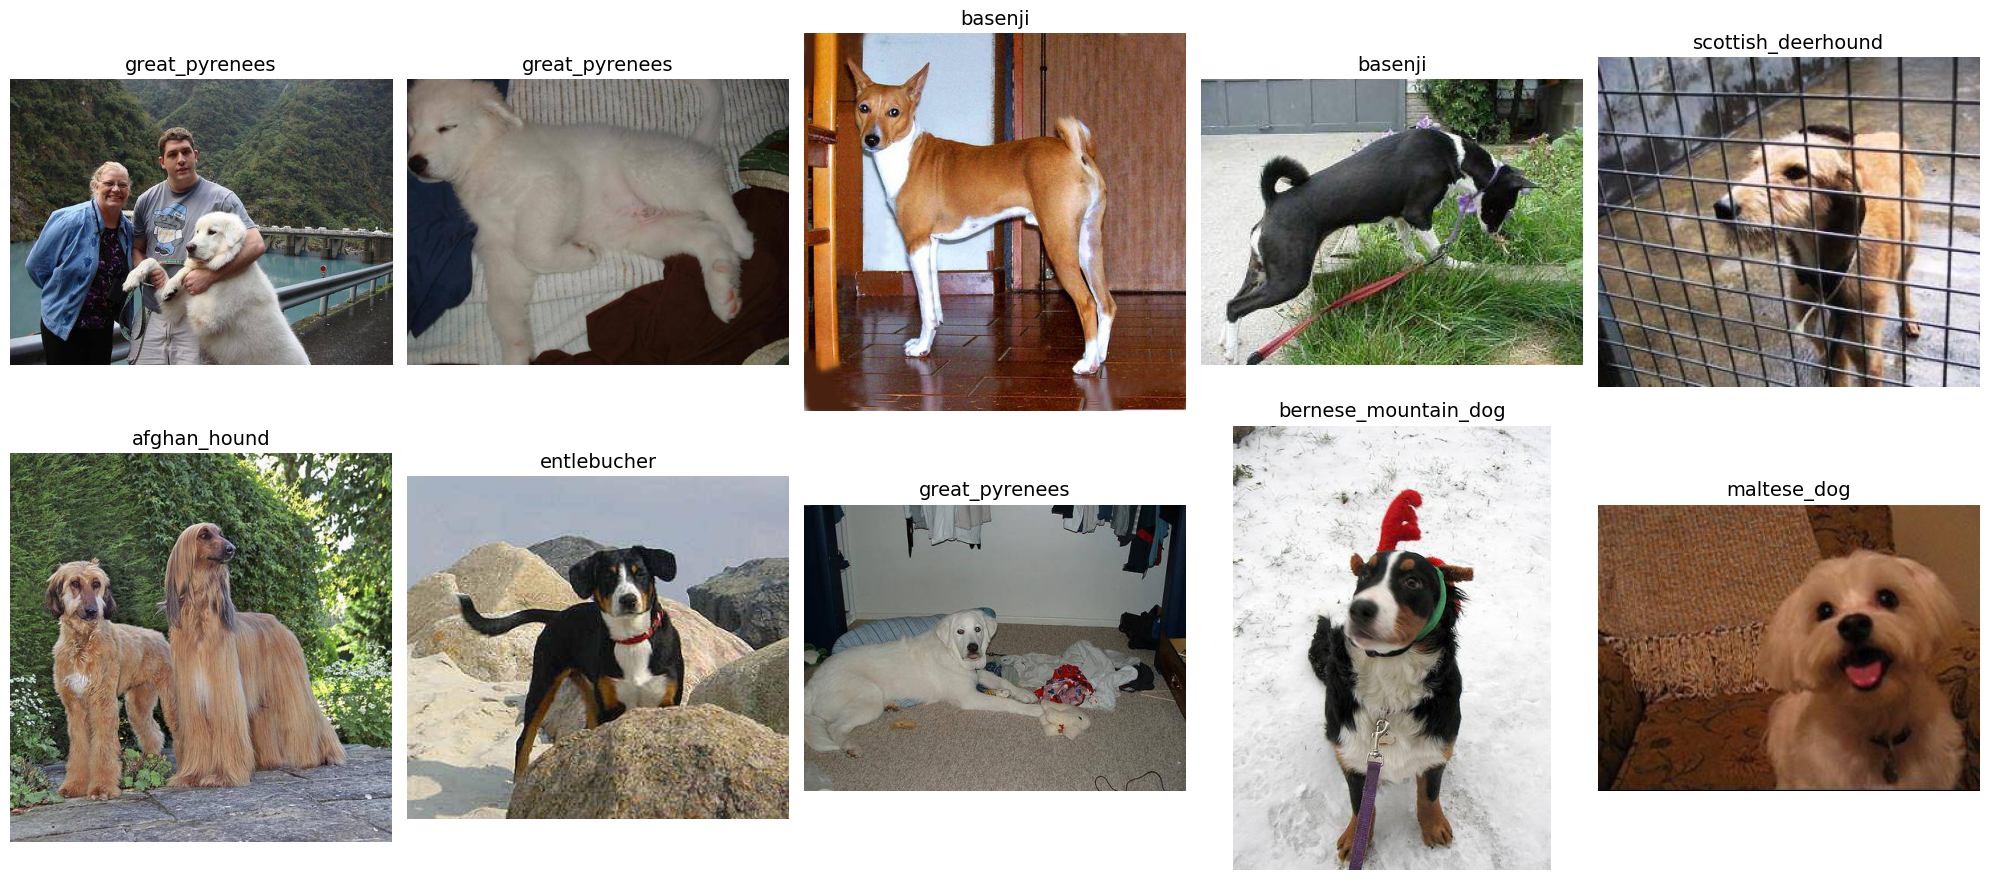

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# Create a figure and a grid of subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 9))

# Flatten the axes array for easy looping
axes = axes.flatten()

# Get the first 10 dogs from your training dataframe
for i, (index, row) in enumerate(train_df.head(10).iterrows()):
    # Construct the full image path
    img_path = os.path.join(IMAGE_DIR, row['id'] + '.jpg')

    # Load the image
    img = load_img(img_path)

    # Display the image on the subplot
    ax = axes[i]
    ax.imshow(img)

    # Set the title of the subplot to the dog's breed
    ax.set_title(row['breed'], fontsize=14)

    # Turn off the axis ticks and labels
    ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Building the Model**

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

IMG_SIZE = (224, 224)
NUM_CLASSES = len(breed_list)  # your number of classes

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5"
feature_extractor = hub.load(feature_extractor_url)  # load as callable

def mobilenet_feature_extractor(x):
    return feature_extractor(x)

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
# Use a Lambda layer to wrap the TF Hub model call
features = tf.keras.layers.Lambda(mobilenet_feature_extractor)(inputs)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(features)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,650 (65.04 KB)

 Trainable params: 16,650 (65.04 KB)

 Non-trainable params: 0 (0.00 B)

**Training the Model**

In [10]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=[earlystop]
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5723 - loss: 1.4487 - val_accuracy: 0.9170 - val_loss: 0.3017
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9539 - loss: 0.1965 - val_accuracy: 0.9345 - val_loss: 0.2043
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9815 - loss: 0.1041 - val_accuracy: 0.9389 - val_loss: 0.1781
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9898 - loss: 0.0773 - val_accuracy: 0.9389 - val_loss: 0.1690
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9924 - loss: 0.0598 - val_accuracy: 0.9345 - val_loss: 0.1658
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9962 - loss: 0.0446 - val_accuracy: 0.9476 - val_loss: 0.1566
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9971 - loss: 0.0391 - val_accuracy: 0.9432 - val_loss: 0.1572
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9973 - loss: 0.0340 - val_accuracy: 0.9389 - val_loss:

**Visualizing Training Results**

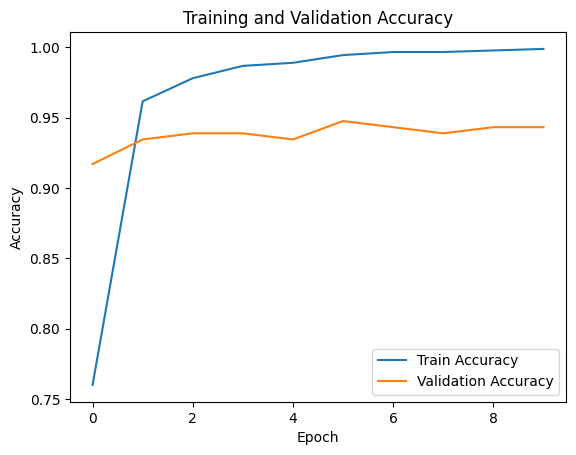

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


**Making Predictions**

In [14]:
def predict_dog_breed(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0).astype(np.float32)

    pred = model.predict(img)
    breed_idx = np.argmax(pred)
    breed = breed_list[breed_idx]
    confidence = pred[0][breed_idx]
    return breed, confidence

# Example prediction
breed, confidence = predict_dog_breed("/content/drive/MyDrive/WWE/dog-breed-identification/train/00a338a92e4e7bf543340dc849230e75.jpg")

print(f"Predicted breed: {breed} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Predicted breed: basenji with confidence 0.97


8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
✅ Overall Validation Accuracy: 0.9432

📊 Classification Report:

                      precision    recall  f1-score   support

             basenji       1.00      1.00      1.00        22
  scottish_deerhound       0.93      1.00      0.96        25
         maltese_dog       0.85      0.96      0.90        24
            shih-tzu       0.95      0.78      0.86        23
             samoyed       0.91      0.91      0.91        22
         entlebucher       1.00      0.96      0.98        23
bernese_mountain_dog       0.96      1.00      0.98        23
        afghan_hound       1.00      0.91      0.95        23
      great_pyrenees       0.95      0.91      0.93        22
          pomeranian       0.92      1.00      0.96        22

            accuracy                           0.94       229
           macro avg       0.95      0.94      0.94       229
        weighted avg       0.95      0.94      0.94       229


🔀 Confusion Matrix:



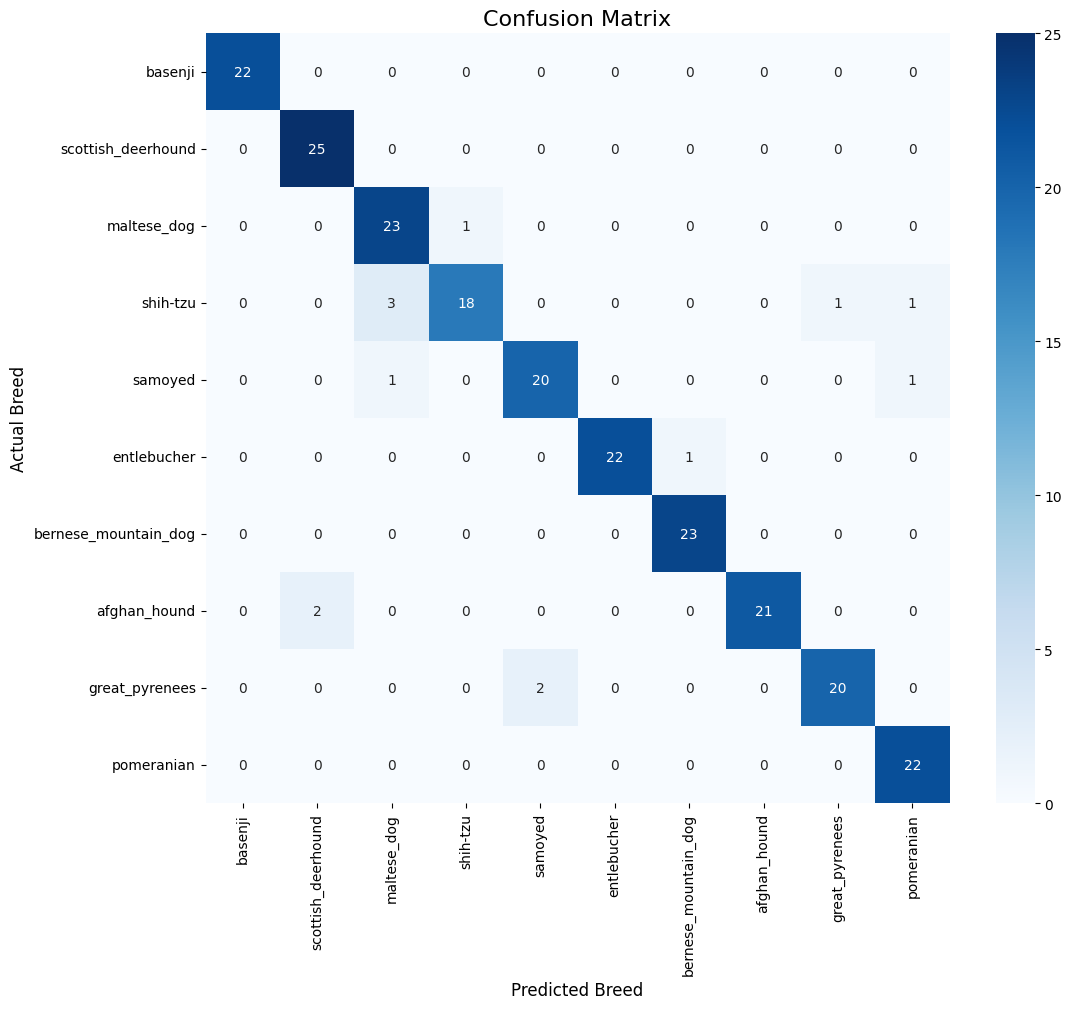

In [13]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get model predictions on the validation set
y_pred_probs = model.predict(X_val)

# Convert predicted probabilities to class labels (0, 1, 2, etc.)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded true labels back to class labels
y_true_classes = np.argmax(y_val, axis=1)

# --- Metrics Calculation and Display ---

# 1. Overall Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"✅ Overall Validation Accuracy: {accuracy:.4f}\n")

# 2. Classification Report (Precision, Recall, F1-Score)
print("📊 Classification Report:\n")
# Use the `breed_list` you created earlier for clear labels
print(classification_report(y_true_classes, y_pred_classes, target_names=breed_list))

# 3. Confusion Matrix
print("\n🔀 Confusion Matrix:\n")
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=breed_list, yticklabels=breed_list)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Breed', fontsize=12)
plt.xlabel('Predicted Breed', fontsize=12)
plt.show()